In [1]:
from PIL import Image, ImageFilter, ImageDraw
import matplotlib.pyplot as plt
from time import time
from skimage.feature import plot_matches
from skimage.transform import pyramid_gaussian

from utils import *

%matplotlib inline

## Blur Test

scales:  [1, 2, 4, 8] 

pyramid layer:  0
scales[i]:  1
scale_coeff1:  (1.0, 1.0)
scale_coeff2:  (1.0, 1.0)
grays1[i] shape:  (450, 800)
grays2[i] shape:  (450, 800)
kp1:  690
kp2:  4501


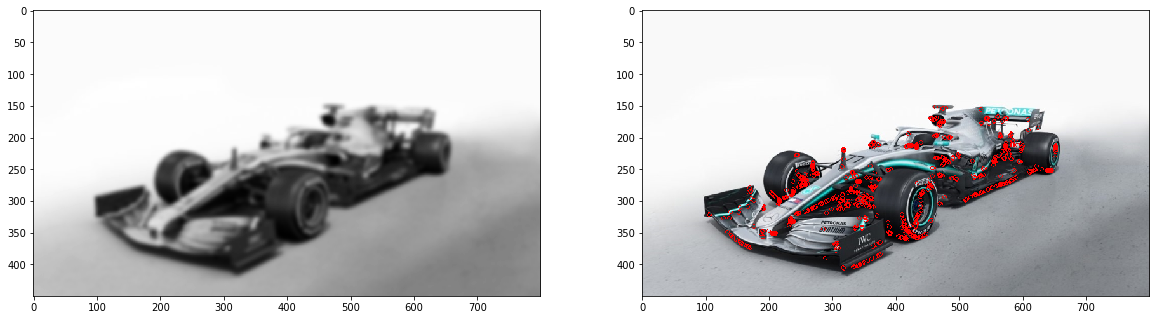

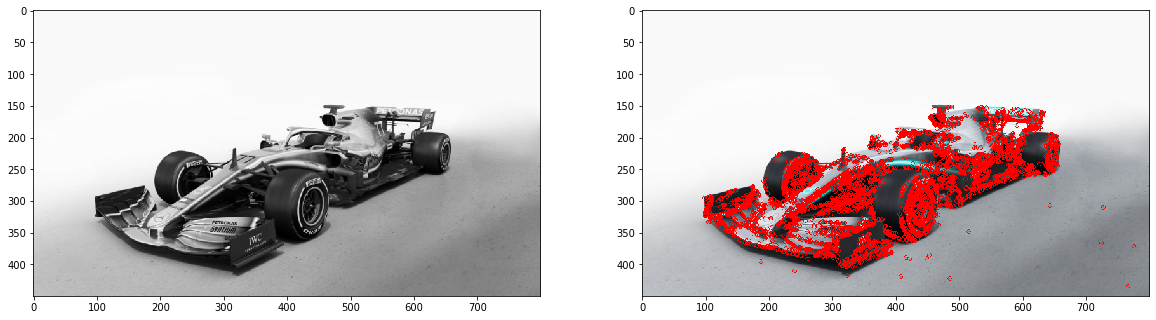

--------------------------------------------------
pyramid layer:  1
scales[i]:  2
scale_coeff1:  (2.0, 2.0)
scale_coeff2:  (2.0, 2.0)
grays1[i] shape:  (225, 400)
grays2[i] shape:  (225, 400)
kp1:  819
kp2:  1473


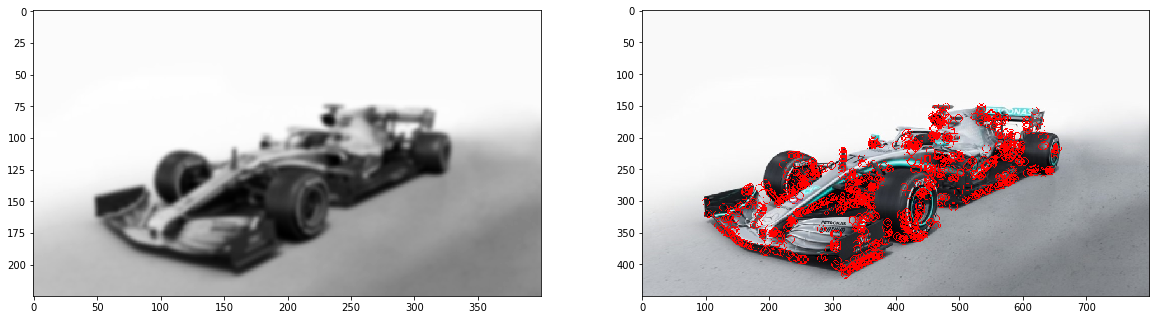

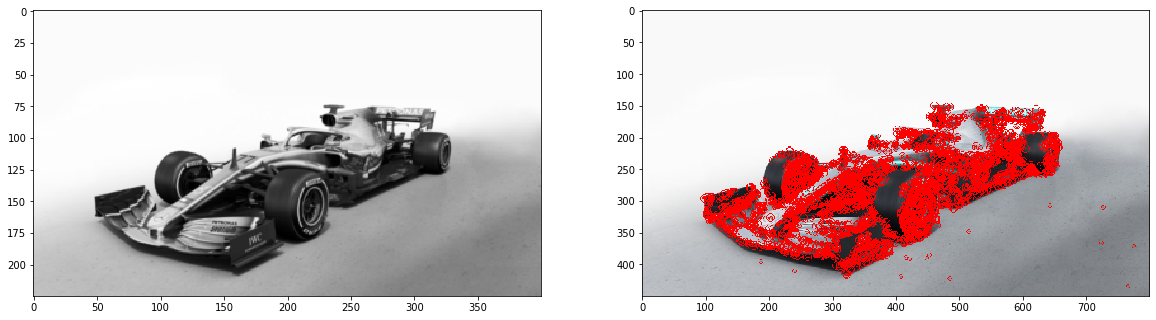

--------------------------------------------------
pyramid layer:  2
scales[i]:  4
scale_coeff1:  (4.0, 3.982300884955752)
scale_coeff2:  (4.0, 3.982300884955752)
grays1[i] shape:  (113, 200)
grays2[i] shape:  (113, 200)
kp1:  380
kp2:  419


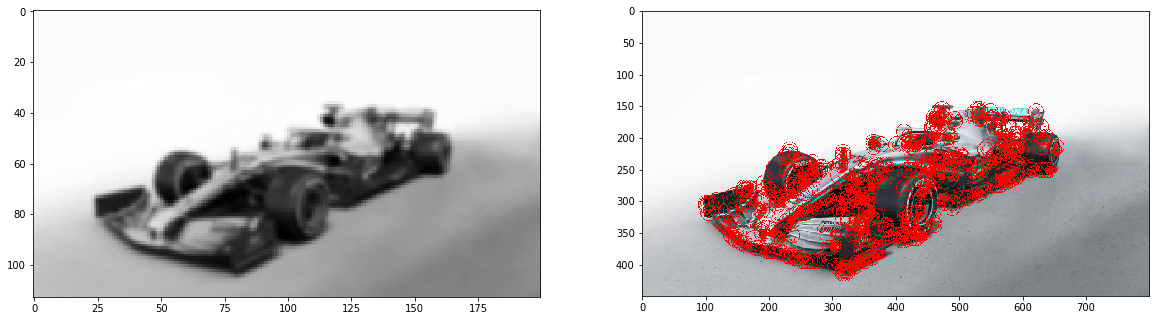

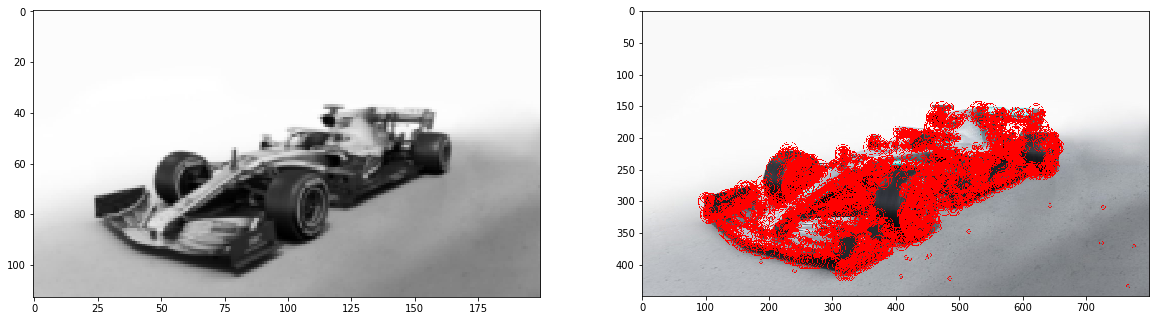

--------------------------------------------------
pyramid layer:  3
scales[i]:  8
scale_coeff1:  (8.0, 7.894736842105263)
scale_coeff2:  (8.0, 7.894736842105263)
grays1[i] shape:  (57, 100)
grays2[i] shape:  (57, 100)
kp1:  114
kp2:  119


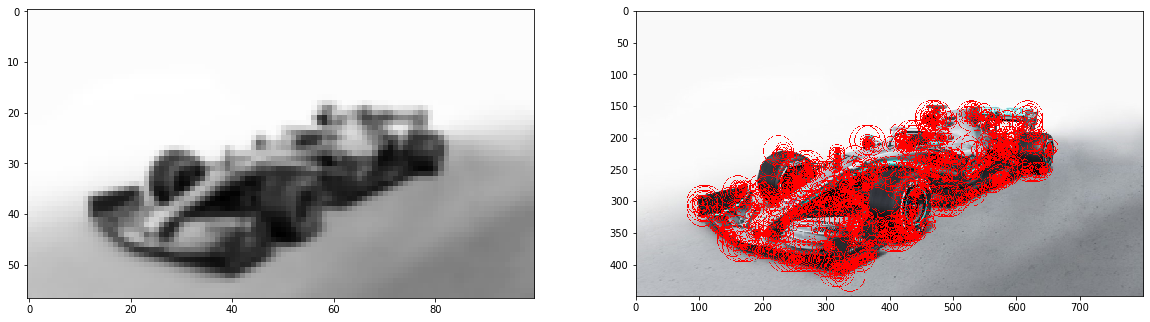

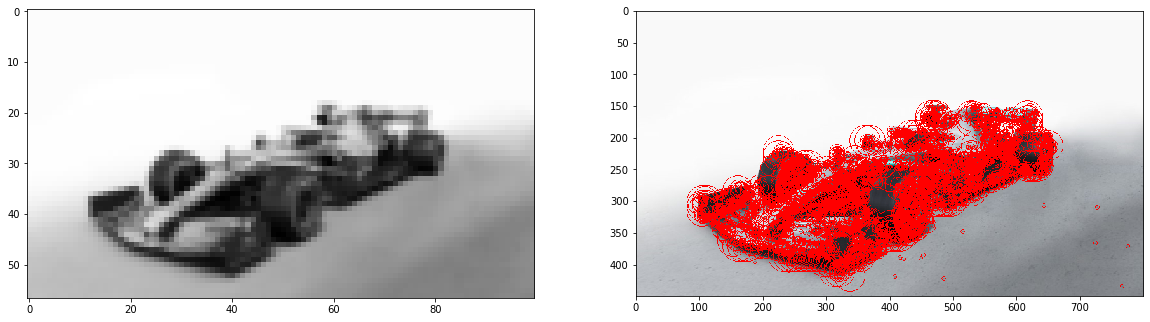

--------------------------------------------------


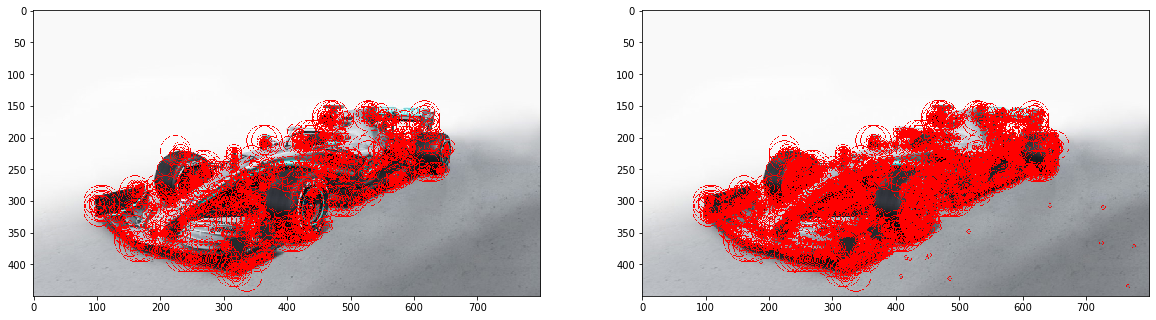

In [2]:
# multi-scale
N_LAYERS = 4
DOWNSCALE = 2

original_img1 = img1 = Image.open('images/car.jpg')
gray1 = img1.convert('L')
gray1 = gray1.filter(ImageFilter.GaussianBlur(radius = 3))
gray1 = np.array(gray1)
grays1 = list(pyramid_gaussian(gray1, downscale=DOWNSCALE, max_layer=N_LAYERS, multichannel=False))

original_img2 = img2 = Image.open('images/car.jpg')
gray2 = img2.convert('L')
gray2 = np.array(gray2)
grays2 = list(pyramid_gaussian(gray2, downscale=DOWNSCALE, max_layer=N_LAYERS, multichannel=False))

scales = [DOWNSCALE**i for i in range(N_LAYERS)]
print('scales: ', scales, '\n')
features_img1 = Image.fromarray(np.copy(img1))
features_img2 = Image.fromarray(np.copy(img2))

kps1 = []
kps2 = []

ds1 = []
ds2 = []

for i in range(N_LAYERS):
    print('pyramid layer: ', i)
    print('scales[i]: ', scales[i])
    scale_coeff1 = (gray1.shape[1]/grays1[i].shape[1], gray1.shape[0]/grays1[i].shape[0])
    scale_coeff2 = (gray2.shape[1]/grays2[i].shape[1], gray2.shape[0]/grays2[i].shape[0])
    
    print('scale_coeff1: ', scale_coeff1)
    print('scale_coeff2: ', scale_coeff2)
    
    print('grays1[i] shape: ', grays1[i].shape)
    print('grays2[i] shape: ', grays2[i].shape)
    
    scale_kp1 = FAST(grays1[i], N=9, threshold=0.1, nms_window=3)
    scale_kp2 = FAST(grays2[i], N=9, threshold=0.1, nms_window=3)
    
    print('kp1: ', len(scale_kp1))
    print('kp2: ', len(scale_kp2))
    
    for keypoint in scale_kp1:
#         features_img1 = cv2.circle(features_img1, tuple(np.round(keypoint*scale_coeff1).astype(np.int32)), int(3*scales[i]), (0,255,0), 1)
        x0 = np.round(keypoint*scale_coeff1)[0]-3*scales[i]
        y0 = np.round(keypoint*scale_coeff1)[1]-3*scales[i]
        x1 = np.round(keypoint*scale_coeff1)[0]+3*scales[i]
        y1 = np.round(keypoint*scale_coeff1)[1]+3*scales[i]
        draw1 = ImageDraw.Draw(features_img1)
        draw1.ellipse([x0,y0,x1,y1], outline='red', width=1)
    for keypoint in scale_kp2:
#         features_img2 = cv2.circle(features_img2, tuple(np.round(keypoint*scale_coeff2).astype(np.int32)), int(3*scales[i]), (0,255,0), 1)
        x0 = np.round(keypoint*scale_coeff2)[0]-3*scales[i]
        y0 = np.round(keypoint*scale_coeff2)[1]-3*scales[i]
        x1 = np.round(keypoint*scale_coeff2)[0]+3*scales[i]
        y1 = np.round(keypoint*scale_coeff2)[1]+3*scales[i]
        draw2 = ImageDraw.Draw(features_img2)
        draw2.ellipse([x0,y0,x1,y1], outline='red', width=1)
        
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(grays1[i], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(features_img1)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(grays2[i], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(features_img2)
    
#     orientations1, orientations2 = None, None
    orientations1 = corner_orientations(grays1[i], scale_kp1)
    orientations2 = corner_orientations(grays2[i], scale_kp2)
    
    if not (len(scale_kp1) == 0 or len(scale_kp2) == 1):
        # avoding errors when no keypoints are computed (happens with small scales - higher pyramid layers)
        kps1.append(np.round(scale_kp1*scale_coeff1).astype(np.int32))
        kps2.append(np.round(scale_kp2*scale_coeff2).astype(np.int32))
        
        d1 = BRIEF(grays1[i], scale_kp1, orientations=orientations1, mode='uniform', n=128)
        d2 = BRIEF(grays2[i], scale_kp2, orientations=orientations2, mode='uniform', n=128)
        ds1.append(d1)
        ds2.append(d2)
    
    plt.show()
    print('-'*50)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(features_img1)
plt.subplot(1,2,2)
plt.imshow(features_img2)
plt.show()

E:\dev\ORB-feature-matching\utils.py:211: RuntimeWarning: invalid value encountered in true_divide
  mask = fc/fs <= 0.5


total matches:  327


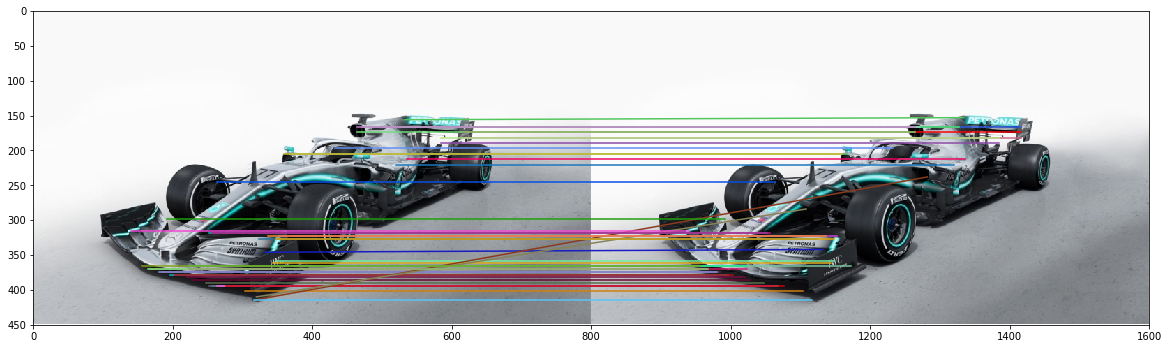

In [3]:
scale_kps1 = np.vstack(kps1)
scale_kps2 = np.vstack(kps2)

scale_ds1 = np.vstack(ds1)
scale_ds2 = np.vstack(ds2)

# Matching is done after computing all keypoints and descriptors to allow for
# the sorting of all descriptors computed on all scales
scale_ms = match(scale_ds1, scale_ds2, cross_check=True, max_distance=np.inf, distance_ratio=0.5)

print('total matches: ', len(scale_ms))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
plot_matches(ax, img1, img2, np.flip(scale_kps1, 1), np.flip(scale_kps2, 1), scale_ms[:50], 
             alignment='horizontal', only_matches=True)

## Scale Invarient

scales:  [1, 2, 4, 8] 

pyramid layer:  0
scales[i]:  1
scale_coeff1:  (1.0, 1.0)
scale_coeff2:  (1.0, 1.0)
grays1[i] shape:  (300, 156)
grays2[i] shape:  (720, 1280)
kp1:  169
kp2:  1268


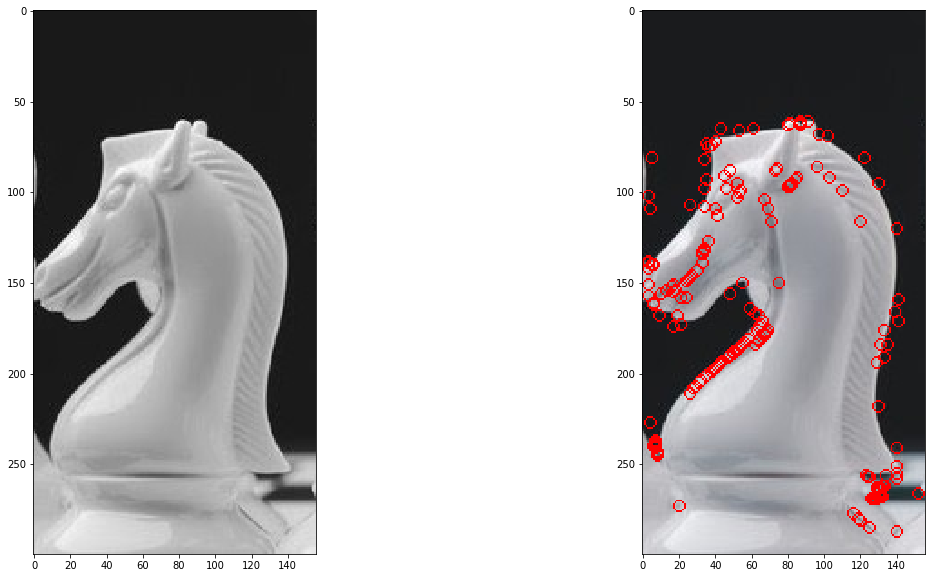

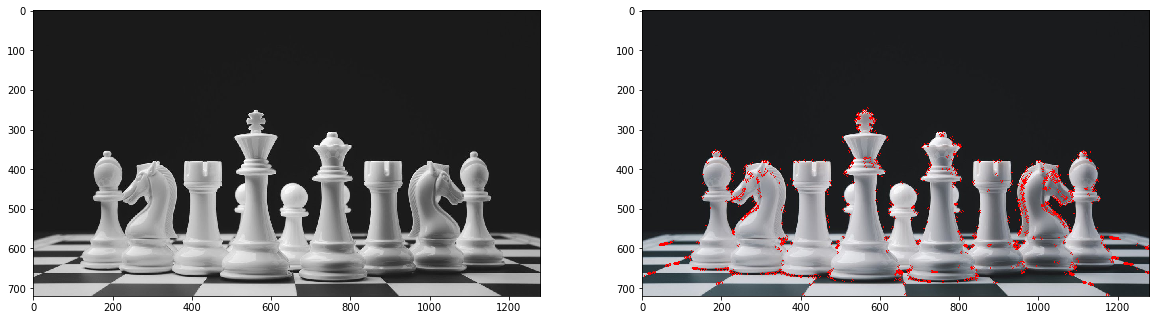

--------------------------------------------------
pyramid layer:  1
scales[i]:  2
scale_coeff1:  (2.0, 2.0)
scale_coeff2:  (2.0, 2.0)
grays1[i] shape:  (150, 78)
grays2[i] shape:  (360, 640)
kp1:  66
kp2:  810


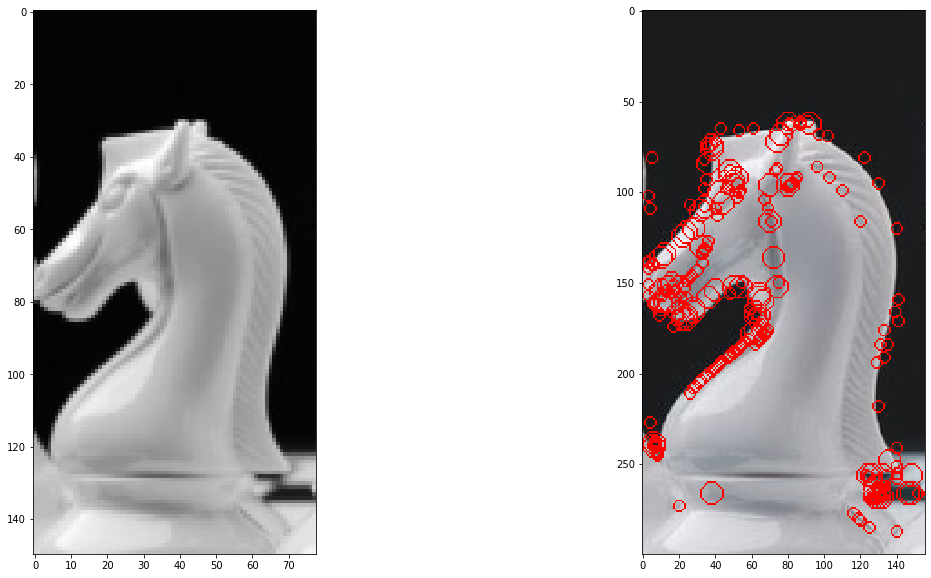

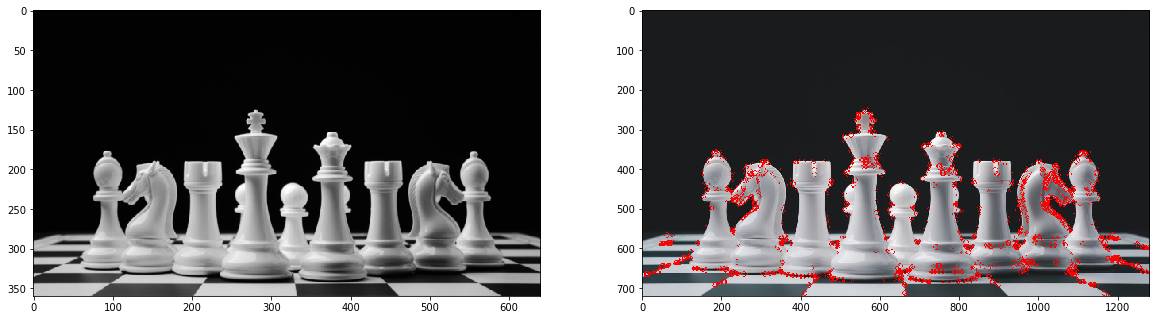

--------------------------------------------------
pyramid layer:  2
scales[i]:  4
scale_coeff1:  (4.0, 4.0)
scale_coeff2:  (4.0, 4.0)
grays1[i] shape:  (75, 39)
grays2[i] shape:  (180, 320)
kp1:  27
kp2:  559


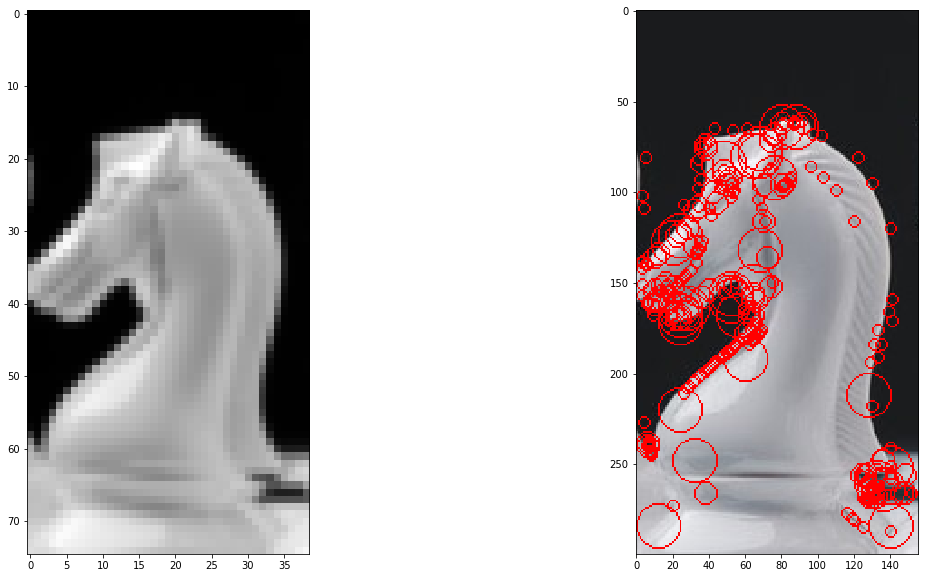

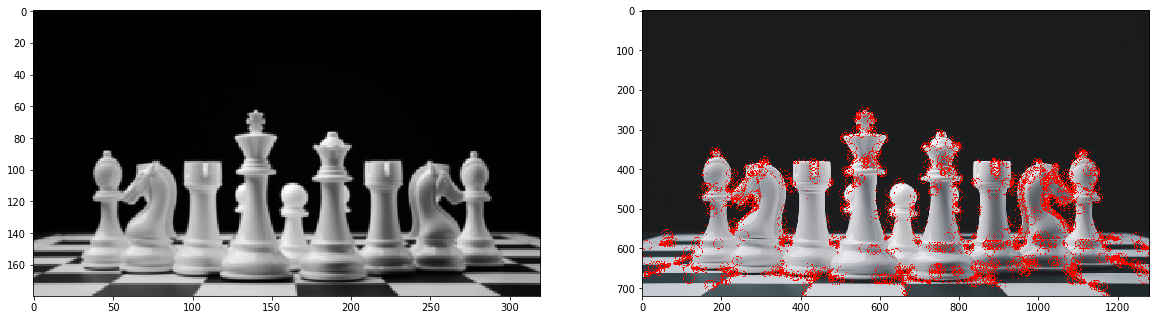

--------------------------------------------------
pyramid layer:  3
scales[i]:  8
scale_coeff1:  (7.8, 7.894736842105263)
scale_coeff2:  (8.0, 8.0)
grays1[i] shape:  (38, 20)
grays2[i] shape:  (90, 160)
kp1:  13
kp2:  315


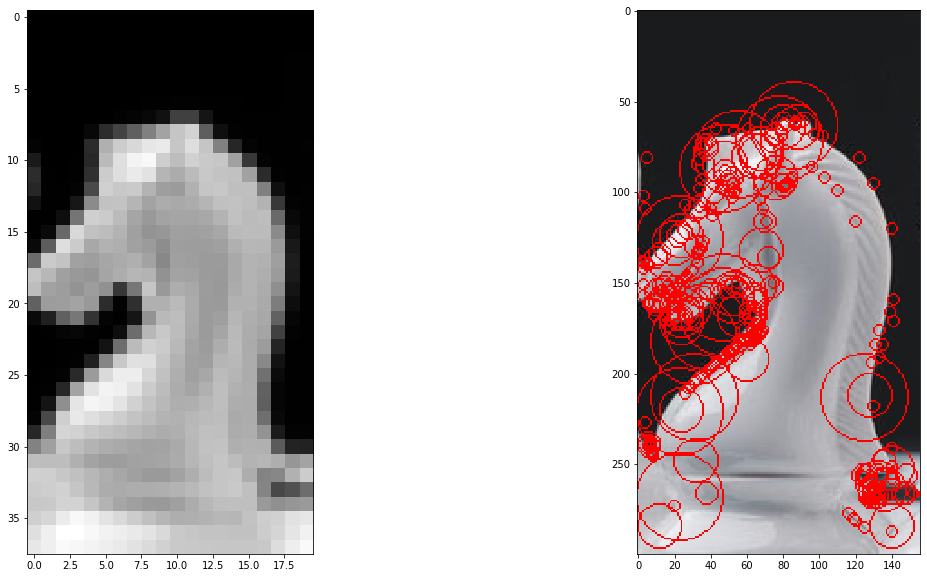

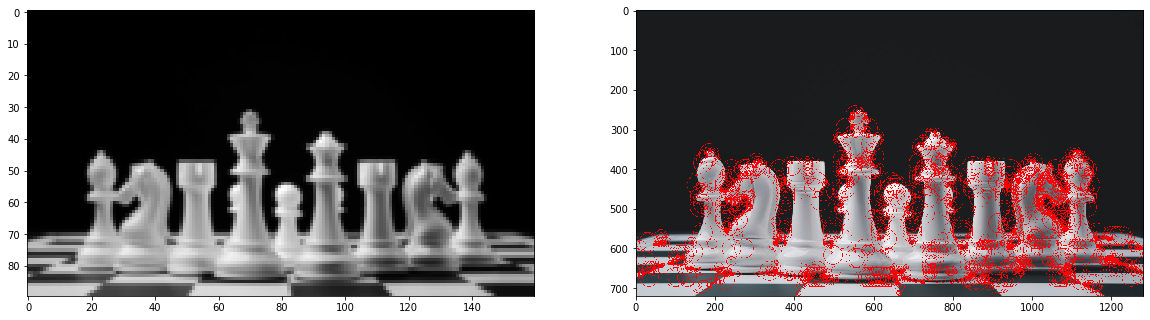

--------------------------------------------------


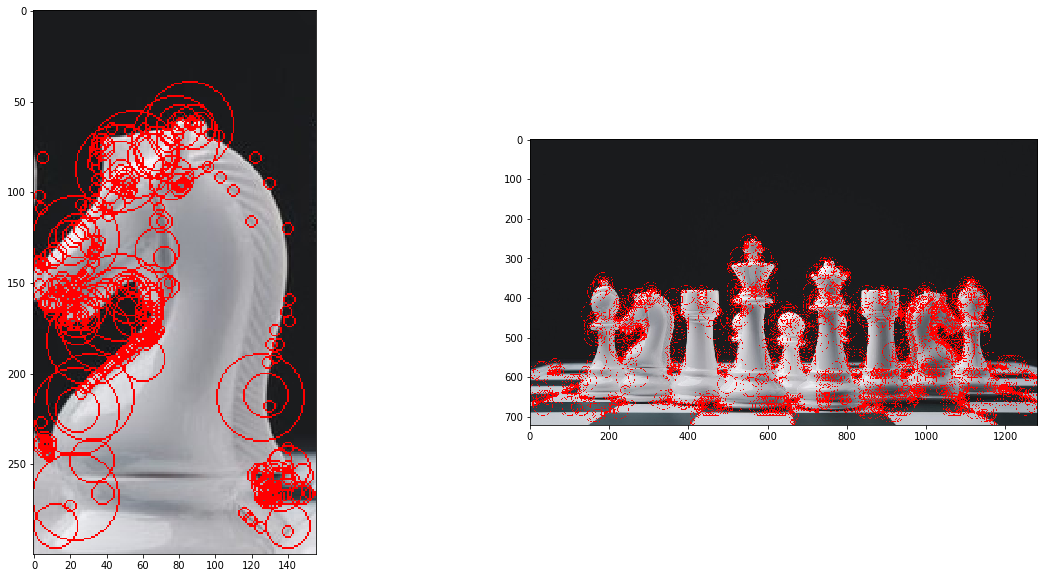

In [4]:
# Trying multi-scale
N_LAYERS = 4
DOWNSCALE = 2

original_img1 = img1 = Image.open('images/chess3.jpg')
gray1 = img1.convert('L')
gray1 = np.array(gray1)
grays1 = list(pyramid_gaussian(gray1, downscale=DOWNSCALE, max_layer=N_LAYERS, multichannel=False))

original_img2 = img2 = Image.open('images/chess.jpg')
gray2 = img2.convert('L')
gray2 = np.array(gray2)
grays2 = list(pyramid_gaussian(gray2, downscale=DOWNSCALE, max_layer=N_LAYERS, multichannel=False))

scales = [DOWNSCALE**i for i in range(N_LAYERS)]
print('scales: ', scales, '\n')
features_img1 = Image.fromarray(np.copy(img1))
features_img2 = Image.fromarray(np.copy(img2))

kps1 = []
kps2 = []

ds1 = []
ds2 = []

for i in range(N_LAYERS):
    print('pyramid layer: ', i)
    print('scales[i]: ', scales[i])
    scale_coeff1 = (gray1.shape[1]/grays1[i].shape[1], gray1.shape[0]/grays1[i].shape[0])
    scale_coeff2 = (gray2.shape[1]/grays2[i].shape[1], gray2.shape[0]/grays2[i].shape[0])
    
    print('scale_coeff1: ', scale_coeff1)
    print('scale_coeff2: ', scale_coeff2)
    
    print('grays1[i] shape: ', grays1[i].shape)
    print('grays2[i] shape: ', grays2[i].shape)
    
    scale_kp1 = FAST(grays1[i], N=9, threshold=0.1, nms_window=3)
    scale_kp2 = FAST(grays2[i], N=9, threshold=0.1, nms_window=3)
    
    print('kp1: ', len(scale_kp1))
    print('kp2: ', len(scale_kp2))
    
    for keypoint in scale_kp1:
#         features_img1 = cv2.circle(features_img1, tuple(np.round(keypoint*scale_coeff1).astype(np.int32)), int(3*scales[i]), (0,255,0), 1)
        x0 = np.round(keypoint*scale_coeff1)[0]-3*scales[i]
        y0 = np.round(keypoint*scale_coeff1)[1]-3*scales[i]
        x1 = np.round(keypoint*scale_coeff1)[0]+3*scales[i]
        y1 = np.round(keypoint*scale_coeff1)[1]+3*scales[i]
        draw1 = ImageDraw.Draw(features_img1)
        draw1.ellipse([x0,y0,x1,y1], outline='red', width=1)
    for keypoint in scale_kp2:
#         features_img2 = cv2.circle(features_img2, tuple(np.round(keypoint*scale_coeff2).astype(np.int32)), int(3*scales[i]), (0,255,0), 1)
        x0 = np.round(keypoint*scale_coeff2)[0]-3*scales[i]
        y0 = np.round(keypoint*scale_coeff2)[1]-3*scales[i]
        x1 = np.round(keypoint*scale_coeff2)[0]+3*scales[i]
        y1 = np.round(keypoint*scale_coeff2)[1]+3*scales[i]
        draw2 = ImageDraw.Draw(features_img2)
        draw2.ellipse([x0,y0,x1,y1], outline='red', width=1)
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(grays1[i], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(features_img1)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(grays2[i], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(features_img2)
    
#     orientations1, orientations2 = None, None
    orientations1 = corner_orientations(grays1[i], scale_kp1)
    orientations2 = corner_orientations(grays2[i], scale_kp2)
    
    if not (len(scale_kp1) == 0 or len(scale_kp2) == 1):
        # avoding errors when no keypoints are computed (happens with small scales - higher pyramid layers)
        kps1.append(np.round(scale_kp1*scale_coeff1).astype(np.int32))
        kps2.append(np.round(scale_kp2*scale_coeff2).astype(np.int32))
        
        d1 = BRIEF(grays1[i], scale_kp1, orientations=orientations1, mode='uniform', n=128)
        d2 = BRIEF(grays2[i], scale_kp2, orientations=orientations2, mode='uniform', n=128)
        ds1.append(d1)
        ds2.append(d2)
    
    plt.show()
    print('-'*50)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(features_img1)
plt.subplot(1,2,2)
plt.imshow(features_img2)
plt.show()

total matches:  107


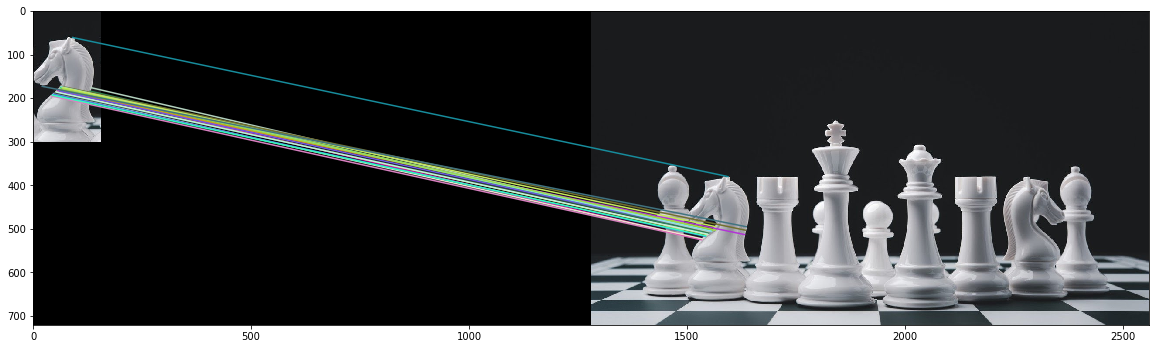

In [5]:
scale_kps1 = np.vstack(kps1)
scale_kps2 = np.vstack(kps2)

scale_ds1 = np.vstack(ds1)
scale_ds2 = np.vstack(ds2)

# Matching is done after computing all keypoints and descriptors to allow for
# the sorting of all descriptors computed on all scales
scale_ms = match(scale_ds1, scale_ds2, cross_check=True, max_distance=np.inf, distance_ratio=0.5)

print('total matches: ', len(scale_ms))

fig = plt.figure(figsize=(20.0, 30.0))
ax = fig.add_subplot(1,1,1)
plot_matches(ax, img1, img2, np.flip(scale_kps1, 1), np.flip(scale_kps2, 1), scale_ms[:20], 
             alignment='horizontal', only_matches=True)